In [1]:
import pandas as pd
import numpy as np
from sklearn import pipeline
from sklearn import base
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import ensemble
import matplotlib.pyplot as plt
import seaborn as sns
from google.cloud import bigquery
import utils as u

In [2]:
pd.set_option('display.max_colwidth', 20)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
from IPython.display import display, HTML
%matplotlib inline
sns.set(style='dark')
plt.rcParams['figure.figsize'] = [14, 10]

In [3]:
# account for inflation?
# add median price per post code l3m?

In [4]:
sample_size = 2
random_seed = 42
test_size = 0.3
cv = 3

In [5]:
queries = u.get_queries('queries')

In [6]:
bq_client = bigquery.Client()

In [7]:
data = u.get_data(queries, 'training_data.sql', bq_client)

In [8]:
data.head()

,ad_id,apt_id,time_s,property_type_apartment,new_building,construction_year,ownership_full,floor,num_bedrooms,address,price_per_sq_m
0,146282788,None,566.0,1,0,1922.0,0,3.0,3.0,"Kirkeveien 80, 0...",69740.0
1,152837849,None,997.0,1,0,1928.0,0,NaN,2.0,Waldemar Thranes...,68420.0
2,144116050,None,1042.0,1,0,1936.0,0,3.0,1.0,"Brandts gate 2A,...",75836.0
3,151909154,None,836.0,1,0,1923.0,0,3.0,2.0,"Åsaveien 1B, 036...",88709.0
4,89625667,B4009,2236.0,1,1,2019.0,0,4.0,4.0,"Gartnerboligen, ...",69750.0


In [9]:
data = data[data.address.notnull()].copy()

In [10]:
data_sample = data.groupby('ad_id').apply(lambda obj: obj.sample(n=sample_size, random_state=random_seed)
                                          if len(obj) > sample_size
                                          else obj.sample(len(obj)))

In [11]:
data = data.set_index(['ad_id', 'apt_id'], drop=True)

In [12]:
class PostCodeExtractor(base.TransformerMixin, base.BaseEstimator):
    '''Extract the post code from the address column
    and drop the address column'''
    
    def __inint__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_c = X.copy()
        X_c['post_code'] = u.get_postcode_from_address(X_c['address'])
        return X_c


class PostCodeEnricher(base.TransformerMixin, base.BaseEstimator):
    '''Extract the post code data from bigquery,
    merge it with the training data.'''
    
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        post_codes = u.get_data(queries, 'post_code_area_name.sql', bq_client).set_index('post_code', drop=True)
        X = X.merge(post_codes, how='left', left_on='post_code', right_index=True)
        return X


class GmapsPlaceEnricher(base.TransformerMixin, base.BaseEstimator):
    '''Extract the gmaps data from bigquery,
    merge it with the training data.'''
    
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        gmaps = u.get_data(queries, 'gmaps_lodging_dining_places.sql', bq_client).set_index('post_code', drop=True)
        X = X.merge(gmaps, how='left', left_on='post_code', right_index=True)
        return X


class NhsDataEnricher(base.TransformerMixin, base.BaseEstimator):
    '''Extract the nhs data from bigquery,
    merge it with the training data.'''
    
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        nhs = u.get_data(queries, 'uni_graduates_by_area_name.sql', bq_client).set_index('area_name', drop=True)
        X = X.merge(nhs, how='left', left_on='area_name', right_index=True)
        return X

class AuxiliaryColumnRemover(base.TransformerMixin, base.BaseEstimator):
    '''Remove the helper columns.'''
    
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X.drop(['post_code', 'area_name', 'settlement_name', 'address'], axis=1, inplace=True)
        return X


class CustomImputer(base.TransformerMixin, base.BaseEstimator):
    '''Impute various columns.'''
    
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        self.columns = X.columns
        return self
    
    def transform(self, X):
        X['floor'].fillna(1, inplace=True)
        X['time_s'].fillna(60 * 60 * 4, inplace=True)
        X['num_bedrooms'].fillna(0, inplace=True)
        X.fillna(0, inplace=True)
        return X

In [13]:
steps = [('extract_post_code', PostCodeExtractor()),
         ('add_area_name', PostCodeEnricher()),
         ('add_gmaps_data', GmapsPlaceEnricher()),
         ('add_nhs_data', NhsDataEnricher()),
         ('remove_helper_columns', AuxiliaryColumnRemover()),
         ('impute_features', CustomImputer()),
         ('scale', preprocessing.MinMaxScaler()),
         ('normalize', preprocessing.Normalizer()),
         ('model', ensemble.AdaBoostRegressor())]

In [14]:
init_model = pipeline.Pipeline(steps)

In [15]:
data.isna().sum(axis=0).sort_values(ascending=False)[:20]

floor                      943
time_s                     147
num_bedrooms               136
price_per_sq_m               0
address                      0
ownership_full               0
construction_year            0
new_building                 0
property_type_apartment      0
dtype: int64

In [16]:
X = data.drop('price_per_sq_m', axis=1)
y = data.price_per_sq_m

In [17]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=test_size, random_state=random_seed)

In [18]:
X_train.shape

(4401, 8)

In [19]:
init_model.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('extract_post_code', PostCodeExtractor()),
                ('add_area_name', PostCodeEnricher()),
                ('add_gmaps_data', GmapsPlaceEnricher()),
                ('add_nhs_data', NhsDataEnricher()),
                ('remove_helper_columns', AuxiliaryColumnRemover()),
                ('impute_features', CustomImputer()),
                ('scale', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('normalize', Normalizer(copy=True, norm='l2')),
                ('model',
                 AdaBoostRegressor(base_estimator=None, learning_rate=1.0,
                                   loss='linear', n_estimators=50,
                                   random_state=None))],
         verbose=False)

In [20]:
def get_learning_curves(estimator, X, y, train_sizes=np.arange(0.1, 1.1, 0.1), score='neg_mean_absolute_error', cv=5):
    train_sizes, train_scores, test_scores = model_selection.learning_curve(estimator, X, y, train_sizes=train_sizes, scoring=score, cv=cv)
    curve_data = pd.DataFrame(columns = range(train_scores.shape[1]))
    for result, result_type in zip([train_scores, test_scores], ['train', 'test']):
        frame = pd.DataFrame(result)
        frame['size'] = train_sizes
        frame['type'] = result_type
        curve_data = curve_data.append(frame, ignore_index = True)
    curve_data = curve_data.melt(id_vars = ['size', 'type'], var_name = 'cv_fit', value_name = 'score')
    return curve_data


def get_cv_res(estimator, X, y, score=['neg_mean_absolute_error'], cv=5):
    cross_val = model_selection.cross_validate(estimator, X, y, scoring=score, cv=cv)
    return cross_val


def print_cv_res(cross_val):
    for key, val in cross_val.items():
        print('Mean {}, {:.2f}'.format(key, val.mean()))

In [21]:
learning_curve_res = get_learning_curves(init_model, X_train, y_train, score='neg_median_absolute_error', cv=cv)

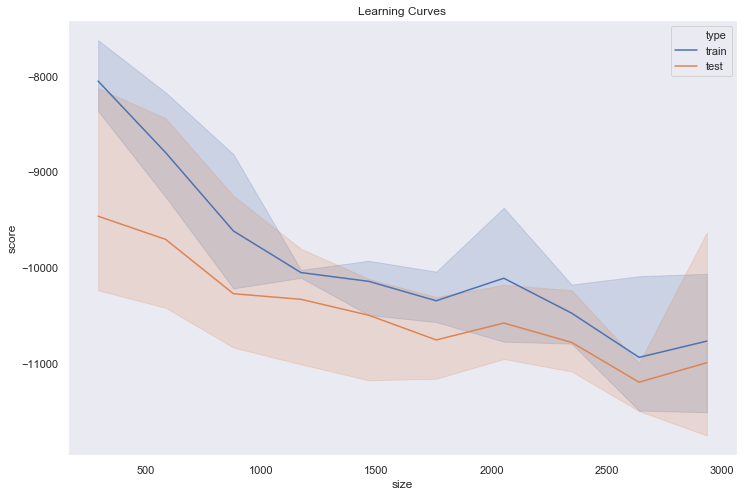

In [22]:
fig = plt.figure(figsize = (12, 8))
plt.title('Learning Curves')
sns.lineplot(x='size', y='score', hue='type', data=learning_curve_res)
plt.show()

In [23]:
cv_res = get_cv_res(init_model,
                    X_train,
                    y_train,
                    score=['neg_median_absolute_error',
                           'r2',
                           'explained_variance',
                           'max_error'],
                    cv=cv)

In [24]:
print_cv_res(cv_res)

Mean fit_time, 1.89
Mean score_time, 6.87
Mean test_neg_median_absolute_error, -11118.19
Mean test_r2, 0.53
Mean test_explained_variance, 0.61
Mean test_max_error, -75162.60


In [25]:
pred = init_model.predict(X_test)

In [26]:
y_pred = pd.Series(pred, index=y_test.index, name='predicted')

In [27]:
y_pred.head()

ad_id      apt_id
134686600  A101      59822.991039
148629223  NaN       73008.486557
147039701  NaN       79866.991453
150491450  NaN       85559.420668
153124055  NaN       60905.842282
Name: predicted, dtype: float64

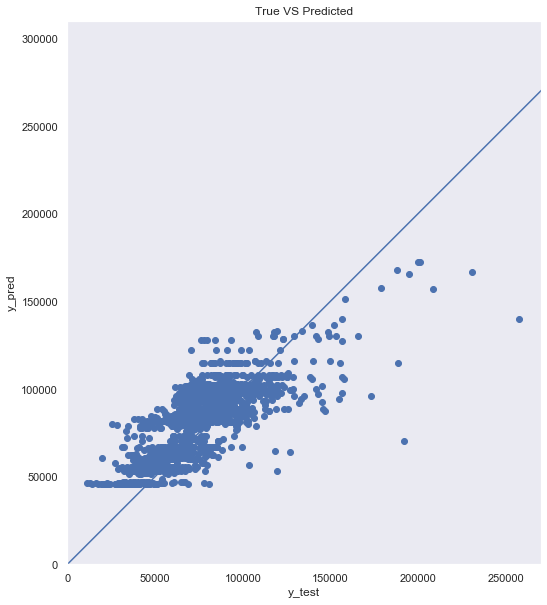

In [28]:
plt.scatter(y_test, y_pred)
plt.xlabel('y_test')
plt.ylabel('y_pred')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-5e7, 5e7], [-5e7, 5e7])
plt.title('True VS Predicted')
plt.show()

In [29]:
to_plot = X_test.join(y_pred).join(y_test)
to_plot['pred_diff'] = to_plot['predicted'] - to_plot['price_per_sq_m']

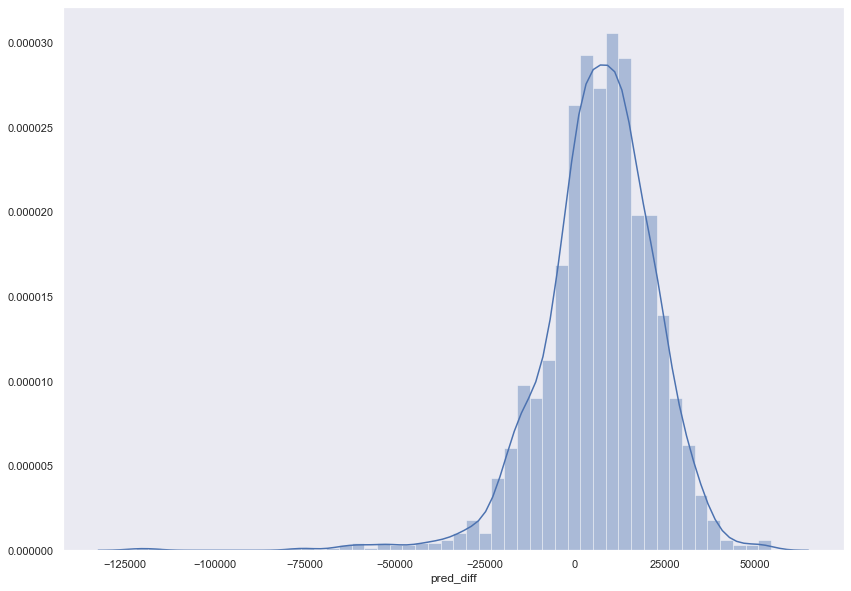

In [30]:
sns.distplot(to_plot.pred_diff)

In [31]:
feature_importances = pd.Series(init_model.named_steps['model'].feature_importances_, index=init_model.named_steps['impute_features'].columns).sort_values(ascending=True)

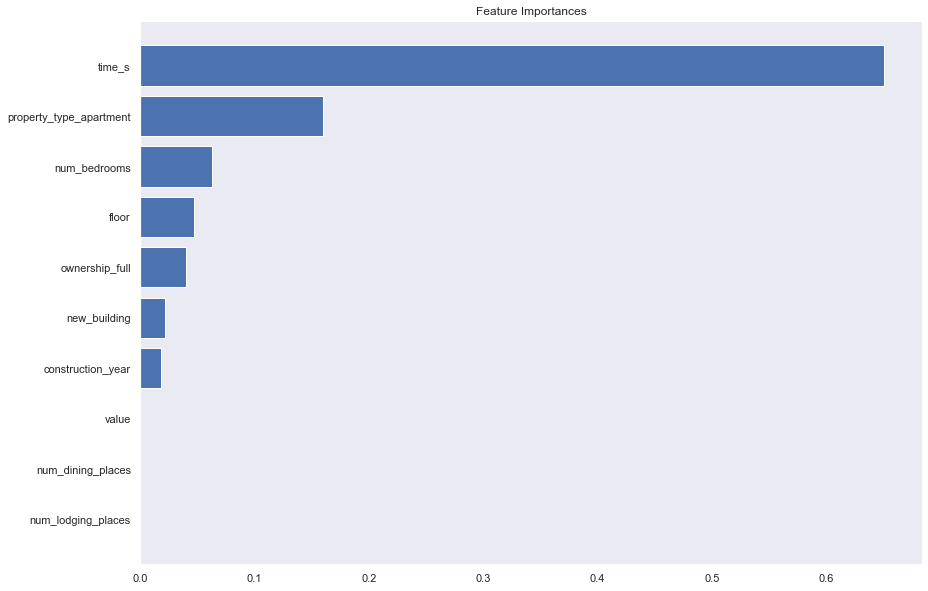

In [32]:
to_plot = feature_importances
plt.yticks(range(len(to_plot)), to_plot.index)
plt.title('Feature Importances')
plt.barh(range(len(to_plot)), to_plot)
plt.show()